# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

git clone https://github.com/sim0nsays/dlcourse_ai.git
cd dlcourse_ai/

virtualenv -p python3.5 .venv
.venv/bin/pip install jupyter notebook tornado\<6 scipy
.venv/bin/jupyter notebook assignments/assignment1/

In [64]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [53]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

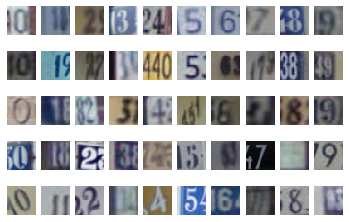

In [54]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

In [55]:
train_X.shape, train_X[train_y == 0][0].shape

((1000, 32, 32, 3), (32, 32, 3))

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [6]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [7]:
binary_train_X.shape, binary_test_X.shape, binary_train_y, train_y

((121, 3072),
 (16, 3072),
 array([ True,  True,  True,  True,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True,  True,
         True, False,  True, False,  True,  True,  True,  True, False,
        False, False,  True,  True,  True, False, False,  True,  True,
        False,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True,
        False,  True, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False,  True, False, False,  True,  True,  True,  True,
         True,  True, False,  True, False,  True, False, False, False,
         True, False,  True, False,  True, False, False,  True,  True,
        False,  True, False,  True, False,  True,  True, False,  True,
        False,  True, False, False, False,  True, False,  True,  True,
         True,  True,  True,  True]),
 array([6, 4

In [8]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

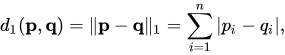

In [9]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)

#assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [10]:
#np.sum(np.abs(binary_test_X[0] - binary_train_X[0]))
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [11]:
A = binary_test_X[0:3]
B = binary_train_X[0:5]
print(A.shape)

num_test = A.shape[0]

I1 = np.repeat(A, 5, axis = 0).reshape(num_test, 5, 3072)
print(I1.shape, I1)

one = np.sum(np.abs(I1 - B), axis = 2)
print("one", one)


#np.abs(I2 - B), np.sum(np.abs(I2 - B), axis = 2).reshape(2,3)


(3, 3072)
(3, 5, 3072) [[[174. 177. 186. ... 209. 212. 219.]
  [174. 177. 186. ... 209. 212. 219.]
  [174. 177. 186. ... 209. 212. 219.]
  [174. 177. 186. ... 209. 212. 219.]
  [174. 177. 186. ... 209. 212. 219.]]

 [[126. 125. 133. ... 140. 138. 149.]
  [126. 125. 133. ... 140. 138. 149.]
  [126. 125. 133. ... 140. 138. 149.]
  [126. 125. 133. ... 140. 138. 149.]
  [126. 125. 133. ... 140. 138. 149.]]

 [[ 36.  36.  58. ...  91.  95.  96.]
  [ 36.  36.  58. ...  91.  95.  96.]
  [ 36.  36.  58. ...  91.  95.  96.]
  [ 36.  36.  58. ...  91.  95.  96.]
  [ 36.  36.  58. ...  91.  95.  96.]]]
one [[179952. 386833. 135249. 241602. 178033.]
 [162721. 177636. 136718. 159877. 104442.]
 [196969. 123306. 217824. 149371. 183932.]]


In [12]:
# TODO: implement compute_distances_one_loop in knn.py
dists1 = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists1[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [13]:
dists1.shape, dists[0:1, 0:10], dists1[0:1, 0:10]

((16, 121),
 array([[179952., 386833., 135249., 241602., 178033., 265134., 172488.,
         260224., 306160., 317740.]], dtype=float32),
 array([[179952., 386833., 135249., 241602., 178033., 265134., 172488.,
         260224., 306160., 317740.]], dtype=float32))

In [14]:
Xn = np.repeat(binary_test_X, binary_train_X.shape[0], axis = 0).reshape(binary_test_X.shape[0], binary_train_X.shape[0], binary_train_X.shape[1])
dists_tmp = np.sum(np.abs(Xn - binary_train_X), axis = 2)

In [15]:
dists_tmp.shape, dists_tmp[0:5, 0:5]

((16, 121), array([[179952., 386833., 135249., 241602., 178033.],
        [162721., 177636., 136718., 159877., 104442.],
        [196969., 123306., 217824., 149371., 183932.],
        [138290., 152141., 156327., 161772., 119463.],
        [142045., 367964., 123586., 211503., 169142.]], dtype=float32))

In [16]:
# TODO: implement compute_distances_no_loops in knn.py
dists2 = knn_classifier.compute_distances_no_loops(binary_test_X)
#assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [17]:
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
dists2[0, 0:10], dists1[0, 0:10]

(array([179952., 386833., 135249., 241602., 178033., 265134., 172488.,
        260224., 306160., 317740.], dtype=float32),
 array([179952., 386833., 135249., 241602., 178033., 265134., 172488.,
        260224., 306160., 317740.], dtype=float32))

In [18]:
q = np.array([ [1,2,3] , [4,5,6]], np.float32).reshape(2*3,1)
o = np.ones((1,4))
q = (q*o).reshape(2, 3, 4)
q
a = np.array([[2,2,2], [1,1,1], [0,0,0], [1,1,1]], np.float32)
s = np.abs(q- a.transpose())
summa = np.sum(s, axis = 1)
summa


array([[ 2.,  3.,  6.,  3.],
       [ 9., 12., 15., 12.]])

In [19]:
num_test = binary_test_X.shape[0]
num_train =  binary_train_X.shape[0]
Xn = (binary_test_X.reshape(num_test*3072, 1) * np.ones((1, num_train))).reshape(num_test, 3072, num_train)
d = np.sum(np.abs(Xn - binary_train_X.transpose()), axis = 1)
d.shape, d

((16, 121), array([[179952., 386833., 135249., ..., 333468., 226102., 128616.],
        [162721., 177636., 136718., ..., 153065.,  63917., 196235.],
        [196969., 123306., 217824., ...,  69135., 159849., 292455.],
        ...,
        [139992., 178517., 105113., ..., 134708.,  82620., 192338.],
        [205567., 118504., 219610., ..., 101701., 187631., 292051.],
        [160404., 127059., 155853., ...,  97218.,  74362., 229166.]]))

In [20]:
dists3 = knn_classifier.compute_distances_no_loops2(binary_test_X)
assert np.isclose(dists3[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
dists3.shape, dists3[0, 0:10]

((16, 121),
 array([179952., 386833., 135249., 241602., 178033., 265134., 172488.,
        260224., 306160., 317740.]))

In [21]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops2(binary_test_X)

35.8 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.75 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.7 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
54.1 ms ± 75.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
arr = np.random.random((5))*100
idx = np.array(np.argpartition(arr, 2)[0:2])
arr, idx, np.sum(arr[idx])

mask = np.array([True, False, True, True, False])
np.sum(mask[idx]), idx

(2, array([3, 0]))

In [23]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X, 1)


In [24]:
k=3
num = 8
mins = np.array(np.argpartition(dists[num], k)[0:k])
pred = np.sum(binary_train_y[mins]) >= k/2    
print(mins, binary_train_y[mins], np.sum(binary_train_y[mins]), pred)

[29 20 94] [ True  True  True] 3 True


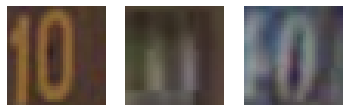

In [25]:
plot_index = 1
for idx in mins:
    plt.subplot(1, 3, plot_index)
    image = binary_train_X[idx].reshape((32,32,3))
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plot_index += 1

[[ True  True False  True]
 [ True  True False  True]
 [ True False  True  True]
 [ True  True False False]] [[ True  True  True False]
 [False  True  True  True]
 [ True False  True False]
 [ True  True  True  True]]


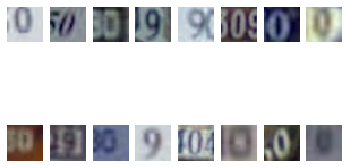

In [26]:
plot_index = 1
for idx in range(binary_test_X.shape[0]):
    plt.subplot(2, 8, plot_index)
    image = binary_test_X[idx].reshape((32,32,3))
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plot_index += 1
print(prediction.reshape(4,4), binary_test_y.reshape(4,4))

In [27]:
tp = np.sum((prediction == binary_test_y) & (prediction == True)) #np.sum((prediction & binary_test_y))
fp = np.sum((prediction != binary_test_y) & (prediction == True))
fn = np.sum((prediction != binary_test_y) & (prediction == False))
tn = np.sum((prediction == binary_test_y) & (prediction == False))
tp, fp, fn, tn, np.sum((prediction & binary_test_y))

(8, 3, 4, 1, 8)

In [28]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [29]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X, 1)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [30]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = np.vsplit(binary_train_X, (24, 48,72, 96))
train_folds_y = np.split(binary_train_y, (24, 48,72, 96))
len(train_folds_X)
# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

5

In [31]:


k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    folds = [0,1,2,3,4]
    sum_f1 = 0
    for fidx in range(num_folds):
        knn_classifier = KNN(k=k)
        cur_X = train_folds_X.copy()
        del cur_X[fidx]
        cur_y = train_folds_y.copy()        
        del cur_y[fidx]
        train_X = np.concatenate(cur_X)
        train_y = np.concatenate(cur_y)
        knn_classifier.fit(train_X, train_y)
        prediction = knn_classifier.predict(train_folds_X[fidx], 1)
        precision, recall, f1, accuracy = binary_classification_metrics(prediction, train_folds_y[fidx])
        sum_f1 += f1
    sum_f1 /= 4;
    k_to_f1[k] = sum_f1


for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 1, f1 = 0.845945
k = 2, f1 = 0.865032
k = 3, f1 = 0.857306
k = 5, f1 = 0.768482
k = 8, f1 = 0.811712
k = 10, f1 = 0.795974
k = 15, f1 = 0.795379
k = 20, f1 = 0.829385
k = 25, f1 = 0.813744
k = 50, f1 = 0.815908


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [32]:
# TODO Set the best k to the best value found by cross-validation
best_k = 50

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 50
Accuracy: 0.69, Precision: 0.73, Recall: 0.92, F1: 0.81


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [82]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=10)
knn_classifier.fit(train_X, train_y)

In [83]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X, num_loops = 1)

[[2 1 3 0]
 [1 1 0 1]
 [2 1 1 9]
 [9 1 0 0]] [[2 1 3 0]
 [2 5 0 1]
 [7 1 6 7]
 [0 9 9 1]]


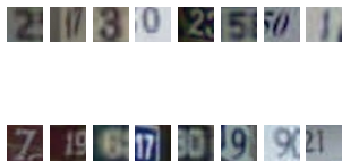

In [84]:
plot_index = 1
for idx in range(16): # test_X.shape[0]):
    plt.subplot(2, 8, plot_index)
    image = test_X[idx].reshape((32,32,3))
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plot_index += 1
print(predict[:16].reshape(4,4), test_y[:16].reshape(4,4))

In [36]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.00


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [ ]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for validation
    # Perform training and produce accuracy metric on the validation dataset
    # Average accuracy from all the folds and write it into k_to_accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [38]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.00
